In [7]:
import importlib
import os, pandas as pd, numpy as np
from joblib import dump, load
from collections import defaultdict
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import sod.core.dataset as scd
importlib.reload(scd)
import sod.core.evaluation as sce
importlib.reload(sce)
from itertools import permutations
import re
from IPython.display import display, HTML
# for printing, we can do this:
# with pd.option_context('display.max_rows', -1, 'display.max_columns', 5):
# or we simply set once here the max_col_width
pd.set_option('display.max_colwidth', 250)

maindir = os.path.abspath(os.path.join(os.getcwd(), '..', 'evaluations/results/'))
assert os.path.isdir(maindir)

print('Loading summary evaluation metrics')
# load summary evaluation metrics, and filter with only those used for testing
sem_df = pd.read_hdf(os.path.join(maindir, 'summary_evaluationmetrics.hdf'))
testsetname = 'allset_test.hdf'
sem_df = sem_df[sem_df.test_set.str.match('^%s$' % testsetname.replace('.', '\\.'))].copy()
sem_df = sem_df[sem_df.model.str.match('.*&n_estimators=(50|100|200)&.*') &
               sem_df.model.str.match('.*&max_samples=(512|2048|8192)&.*')]
assert len(sem_df) == 279 * 2
print('Found %d evaluation metrics of %d models computed on test set "%s"' % (len(sem_df), len(sem_df), testsetname))


sem_df_tmp = sem_df.drop_duplicates(subset=['model', 'test_set'])
assert len(sem_df_tmp) == len(sem_df)

print('Fetching unique features used:')
numfeat2featlist = defaultdict(set)
for _ in sem_df.model:
    feats = re.match('.*&feats=(.+?)&.*', _).group(1).split(',')
    feats = [re.match('psd@(.+?)sec', _).group(1) for _ in feats]
    feats = tuple(sorted(feats, key=float))
    numfeats = len(feats)
    numfeat2featlist[len(feats)].add(tuple(feats))
# now sort first by num features, then by sum of psd periods
feat_tuples = []
for i in range(np.min(list(numfeat2featlist.keys())), 1+np.max(list(numfeat2featlist.keys()))):
    feat_tuples.extend(sorted(numfeat2featlist[i]))
assert len(feat_tuples) == 31
print(feat_tuples)


# define a function to get the metrics we want based on filters:    
def get_metrics(psd_periods=None, n_estimators=None, max_samples=None):
    '''Returns the rows of the evaluationmetrics dataframe matching the given criteria
    
    :param psd_periods: list of floats or strings denoting the PSD poeriods. They do not need to be
        sorted
    '''
    ret = sem_df
    if n_estimators is not None:
        ret = ret[ret.model.str.match('^.+&n_estimators=%s($|&.*)' % str(n_estimators))]
    if max_samples is not None:
        ret = ret[ret.model.str.match('^.+&max_samples=%s($|&.*)' % str(max_samples))]
    if psd_periods:
        # Now, psd_periods can be given as strings '0.5' '5.0' '5'
        # as ints , or floats. Thus assure uniqueness:
        psd_periods_str = []
        for _ in psd_periods:
            _ = float(_)
            if _ == int(_):
                psd_periods_str.append(str(int(_)))  # this makes 5, 5.0, '5' ALL INTO '5'
            else:
                psd_periods_str.append(str(_))  # this makes
        flt = None
        # check for any permutation of the psd periods,
        # order should have been written consistently but we can not know
        for periods in permutations(psd_periods_str):
            key = ','.join('psd@%ssec' % _ for _ in periods)
            key = '^.+&feats=%s($|&.*)' % key
            flt_ = ret.model.str.match(key)
            if not flt_.any():  # or with False is useless
                continue
            if flt is None:
                flt = flt_
            else:
                flt |= flt_
        # now filter:
        if flt is not None:
            ret = ret[flt]
    return ret.copy()

# there are 31 different features permutation, *3 max_samples, * 3 n_estimators. Thus
assert len(get_metrics(n_estimators=50)) == (3 * 2) * 31
assert len(get_metrics(n_estimators=50, max_samples=512)) == 31 * 2
assert len(get_metrics([2, 5, 0.5])) == len(get_metrics([0.5, 2, 5])) == 9 * 2
assert len(get_metrics([0.2, 0.5, 1.0, 2.0, 5.0])) == 9 * 2
assert len(get_metrics(['0.2', '0.5', '1.0', '2.0', '5.0'])) == 9 * 2
assert len(get_metrics([0.2, 0.5, 1.0, 2.0, 5.0], 50, 512)) == 1 * 2

print('Summary evaluation metrics (first rows only):')
display(sem_df.head())

print('DONE')

Loading summary evaluation metrics
Found 558 evaluation metrics of 558 models computed on test set "allset_test.hdf"
Fetching unique features used:
[('0.2',), ('0.5',), ('1',), ('2',), ('5',), ('0.2', '0.5'), ('0.2', '1'), ('0.2', '2'), ('0.2', '5'), ('0.5', '1'), ('0.5', '2'), ('0.5', '5'), ('1', '2'), ('1', '5'), ('2', '5'), ('0.2', '0.5', '1'), ('0.2', '0.5', '2'), ('0.2', '0.5', '5'), ('0.2', '1', '2'), ('0.2', '1', '5'), ('0.2', '2', '5'), ('0.5', '1', '2'), ('0.5', '1', '5'), ('0.5', '2', '5'), ('1', '2', '5'), ('0.2', '0.5', '1', '2'), ('0.2', '0.5', '1', '5'), ('0.2', '0.5', '2', '5'), ('0.2', '1', '2', '5'), ('0.5', '1', '2', '5'), ('0.2', '0.5', '1', '2', '5')]
Summary evaluation metrics (first rows only):


,model,test_set,log_loss,roc_auc_score,average_precision_score,best_th_roc_curve,best_th_pr_curve
0,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=42.sklmodel,allset_test.hdf,0.518215,0.840979,0.890645,0.662301,0.548673
1,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=200&random_state=42.sklmodel,allset_test.hdf,0.522542,0.833812,0.887297,0.664732,0.547225
2,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=42.sklmodel,allset_test.hdf,0.523112,0.823629,0.882456,0.683218,0.562411
3,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=42.sklmodel,allset_test.hdf,0.542338,0.843009,0.891654,0.710406,0.584993
4,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=200&random_state=42.sklmodel,allset_test.hdf,0.545601,0.843847,0.890219,0.711883,0.586768


DONE


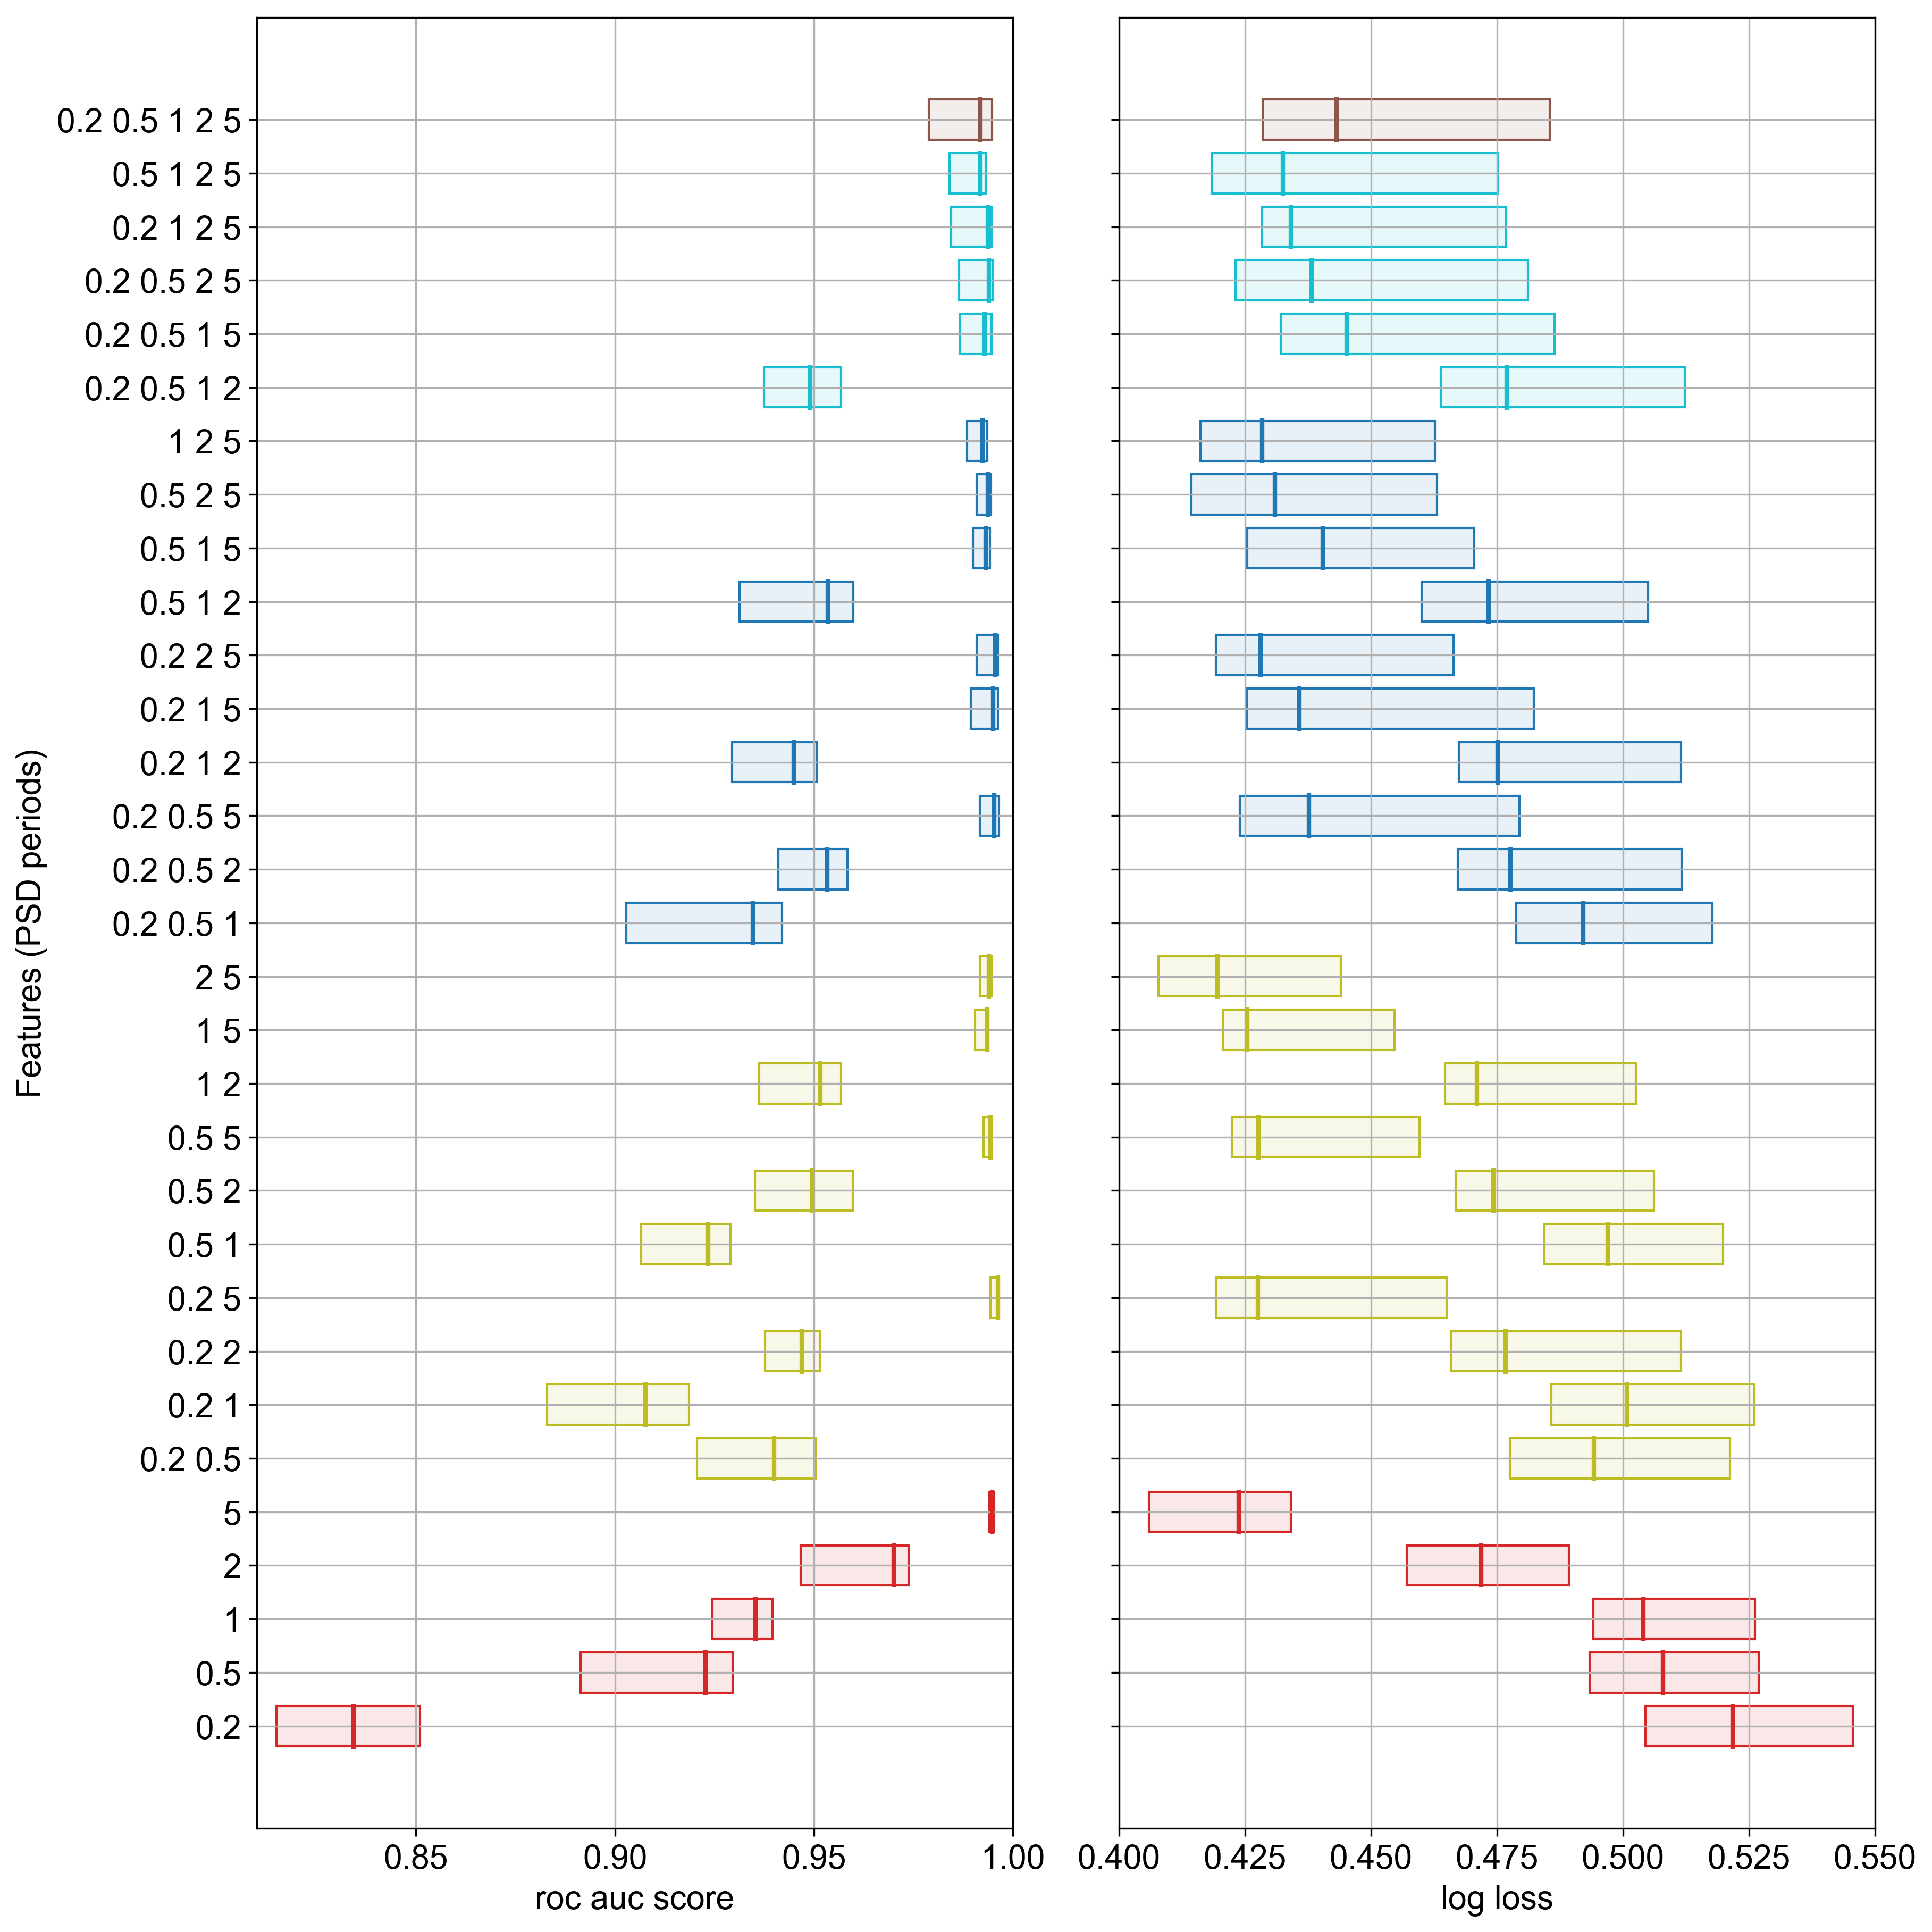

In [17]:
import matplotlib
importlib.reload(matplotlib)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 15
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'helvetica,arial'

# score_names = ['roc_auc_score', 'average_precision_score', 'log_loss']
score_names = ['roc_auc_score', 'log_loss']

# base colors are alternate after inspecting them in a grayscale screen
# to make them recognizable also in black and white printouts:
basecolors = [
    'tab:red',
    'tab:olive',
    'tab:blue',
    'tab:cyan',
    'tab:brown',
    'tab:green',
    'tab:orange',
    'tab:pink',
    'tab:purple',
    'tab:gray',
]


def plot_scores():
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(1, len(score_names))
                          #height_ratios=heights,
                          #width_ratios=[1, 1, 1])

    for j, score_name in enumerate(score_names):
        ax = fig.add_subplot(gs[0, j])
        for i, feat_tuple in enumerate(feat_tuples):
            df_ = get_metrics(feat_tuple)
            min_, median, max_ =  df_[score_name].min(), df_[score_name].median(), df_[score_name].max()

            xerr = [[median-min_], [max_-median]]
            color = basecolors[len(feat_tuple)-1]

            # barh(self, y, width, height=0.8, left=None, *, align='center', **kwargs)[source]
            ax.barh(i, left=min_, width=max_-min_, height=0.75, alpha=0.1, color=color, linewidth=0)
            ax.barh(i, left=min_, width=max_-min_, height=0.75, alpha=1, fill=False, ec=color, linewidth=1)

            ax.errorbar(median, i, xerr=xerr, color=color,
                        marker='|', capsize=0,
                        linewidth=0, elinewidth=0, capthick=0, markersize=20, mew=2)


            ax.set_yticks(list(range(len(feat_tuples))))
            if j == 0:
                ax.set_ylabel('Features (PSD periods)')
                ax.set_yticklabels(' '.join(_) for _ in feat_tuples)  # ["".join("2.2f" % _ for _ in get_periods(lbl)) for lbl in labels])
            else:
                ax.set_yticklabels([])

            if score_name == 'roc_auc_score':
                ax.set_xlim([.81, 1])  # ax.set_xlim([.975, .9975])
            elif score_name == 'average_precision_score':
                ax.set_xlim([.975, .9975])
            elif score_name == 'log_loss':
                ax.set_xlim([.4, .55])  # ax.set_xlim([.4, .5])

            ax.set_xlabel(score_name.replace('_', ' '))
            ax.grid()

plot_scores()

In [10]:
# Let's do  acheck of the different scores and variability
for psds in [(2, 5), (0.2, 5), (5,)]:
    print()
    print('PERIODS: ' + str(psds))
    for meas in ['roc_auc_score', 'average_precision_score', 'log_loss']:
        min_, max_ = get_metrics(psds)[meas].min(), get_metrics(psds)[meas].max()
        range_ = np.abs(max_ - min_)
        print("%s has a maximum abs. difference of %f (%f -> %f)" % (meas, range_, min_, max_))
    




PERIODS: (2, 5)
roc_auc_score has a maximum abs. difference of 0.003009 (0.991702 -> 0.994711)
average_precision_score has a maximum abs. difference of 0.005021 (0.990575 -> 0.995595)
log_loss has a maximum abs. difference of 0.036272 (0.407778 -> 0.444050)

PERIODS: (0.2, 5)
roc_auc_score has a maximum abs. difference of 0.002098 (0.994411 -> 0.996510)
average_precision_score has a maximum abs. difference of 0.003157 (0.993762 -> 0.996919)
log_loss has a maximum abs. difference of 0.045832 (0.419189 -> 0.465021)

PERIODS: (5,)
roc_auc_score has a maximum abs. difference of 0.001319 (0.994056 -> 0.995374)
average_precision_score has a maximum abs. difference of 0.001620 (0.994121 -> 0.995741)
log_loss has a maximum abs. difference of 0.028128 (0.405938 -> 0.434066)


In [11]:
# print the evaluation metrics jsut to inspect it:
opt = pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', 200)
sem_df.sort_values(['roc_auc_score'], ascending=False)[['model', 'roc_auc_score', 'log_loss']]

,model,roc_auc_score,log_loss
359,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@0.5sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=50&random_state=11.sklmodel",0.996543,0.423909
420,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=100&random_state=11.sklmodel",0.996510,0.419189
142,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=200&random_state=42.sklmodel",0.996491,0.427080
422,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=50&random_state=11.sklmodel",0.996456,0.419360
135,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=42.sklmodel",0.996444,0.425237
421,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=200&random_state=11.sklmodel",0.996443,0.422237
411,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=100&random_state=11.sklmodel",0.996424,0.420922
141,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=100&random_state=42.sklmodel",0.996418,0.422850
143,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=50&random_state=42.sklmodel",0.996387,0.427758
136,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=200&random_state=42.sklmodel",0.996361,0.430935


In [13]:
n_estim = np.array([50, 100, 200])
max_samp = np.array([512, 2048, 8192])
bestfeats = [
    [5],
    [0.2, 5],
    [0.5, 5],
    [1, 5],
    [2, 5],
    [0.2, 0.5, 5],
    [0.2, 1, 5],
    [0.2, 2, 5],
    [0.5, 1, 5],
    [0.5, 2, 5],
    [1, 2, 5],
    [2, 5]
]

df_median = pd.DataFrame(data=0, index=n_estim, columns=max_samp)
df_max = pd.DataFrame(data=0, index=n_estim, columns=max_samp)
df_var = pd.DataFrame(data=0, index=n_estim, columns=max_samp)

for n_estimators in n_estim:
    for max_samples in max_samp:
        vals = []
        for f in bestfeats:
            vals.extend(_ for _ in get_metrics(f, n_estimators=n_estimators, max_samples=max_samples).roc_auc_score)
        assert len(vals) == len(bestfeats)*2
        df_median.loc[n_estimators, max_samples] = np.nanmedian(vals)
        df_max.loc[n_estimators, max_samples] = np.nanmax(vals)
        df_var.loc[n_estimators, max_samples] = np.std(vals)

print()
print('Median roc auc values for features including psd@5sec')
print('x axis: max_samples, y axis: n_estimators')
display(df_median)

print()
print('Max roc auc values for features including psd@5sec')
print('x axis: max_samples, y axis: n_estimators')
display(df_max)


print()
print('Stdev roc auc values for features including psd@5sec')
print('x axis: max_samples, y axis: n_estimators')
display(df_var)

# plt.scatter( wine_df['Alcohol'], wine_df['Color intensity'] , c=c, 
#             cmap = 'RdPu', s = wine_df['Proline']*.5, alpha =0.5)
# cbar = plt.colorbar()
# cbar.set_label('Color Intensity')


Median roc auc values for features including psd@5sec
x axis: max_samples, y axis: n_estimators


,512,2048,8192
50,0.992255,0.993955,0.994597
100,0.992485,0.994425,0.994504
200,0.992642,0.994371,0.994394



Max roc auc values for features including psd@5sec
x axis: max_samples, y axis: n_estimators


,512,2048,8192
50,0.995701,0.996212,0.996543
100,0.995354,0.996444,0.996510
200,0.995097,0.996361,0.996491



Stdev roc auc values for features including psd@5sec
x axis: max_samples, y axis: n_estimators


,512,2048,8192
50,0.001762,0.001443,0.001109
100,0.001492,0.001170,0.001133
200,0.001403,0.001030,0.001119


,model,test_set,log_loss,roc_auc_score,average_precision_score,best_th_roc_curve,best_th_pr_curve
359,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@0.5sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=50&random_state=11.sklmodel",allset_test.hdf,0.423909,0.996543,0.996693,0.559843,0.559843
422,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=50&random_state=11.sklmodel",allset_test.hdf,0.419360,0.996456,0.996919,0.592119,0.592119
143,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=50&random_state=42.sklmodel",allset_test.hdf,0.427758,0.996387,0.996584,0.576709,0.576709
395,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@1sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=50&random_state=11.sklmodel",allset_test.hdf,0.425372,0.996216,0.996367,0.561477,0.561477
413,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=50&random_state=11.sklmodel",allset_test.hdf,0.422198,0.996055,0.996292,0.560672,0.560672


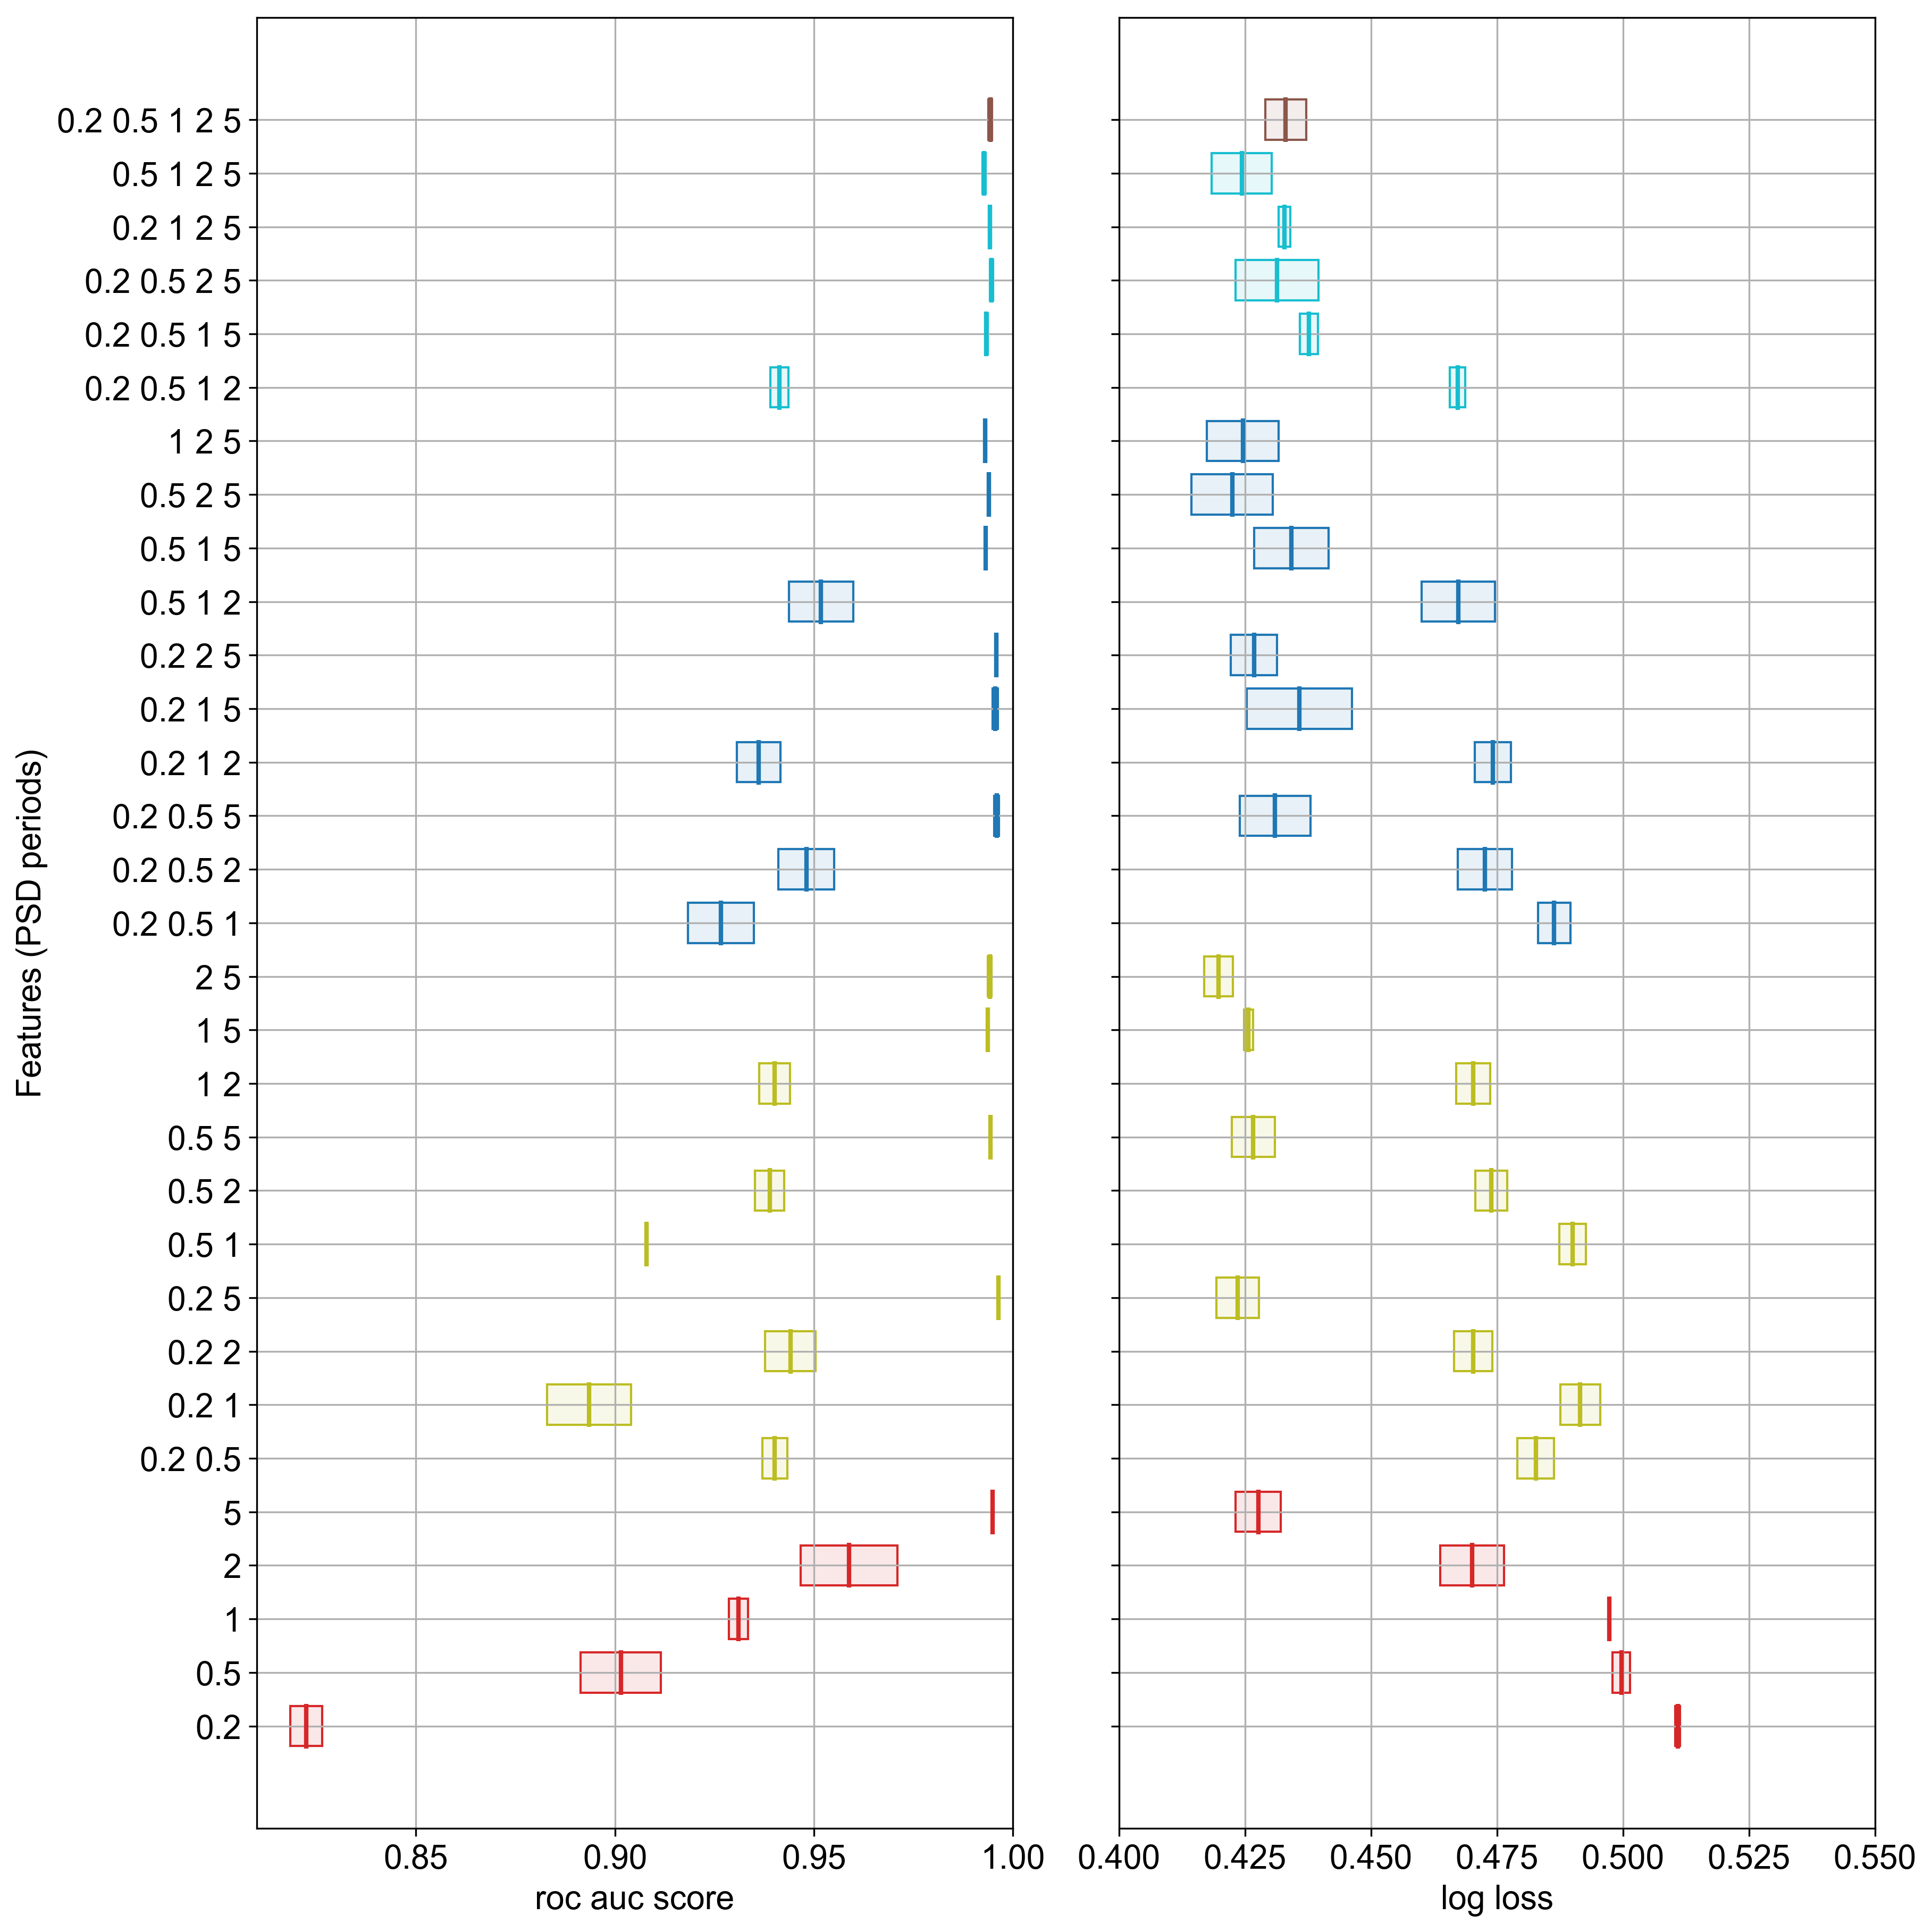

In [19]:
opt = pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', 200)
dfs = []
for f in feat_tuples:
    dfs.append(get_metrics(f, 50, 8192))
_sem_df = pd.concat(dfs, axis=0, sort=False, copy=True).drop_duplicates(subset=['model', 'test_set'])
display(_sem_df.sort_values(['roc_auc_score'], ascending=False).head())

tmp = sem_df
sem_df = _sem_df
plot_scores()
sem_df = tmp

# _sem_df.sort_values(['model', 'roc_auc_score'], ascending=False)[['model', 'test_set', 'roc_auc_score', 'best_th_pr_curve', 'best_th_roc_curve', 'log_loss']]

In [54]:
from IPython.display import display, HTML

#opt = pd.get_option('display.max_colwidth')
#pd.set_option('display.max_colwidth', 200)
dfs = []
for f in bestfeats:
    dfs.append(get_metrics(f, 50, 8192))

_sem_df = pd.concat(dfs, axis=0, sort=False)
# display(HTML(_sem_df.to_html()))

diffs = defaultdict(list)

for model, score in zip(_sem_df.model, _sem_df.roc_auc_score):
#     model = _.iloc[0, 0]
#     score = _.iloc[0, 1]
    model_ = re.sub('random_state=\\d+', '', model)
    diffs[model_].append(score)

absdiffs = []
for vals in diffs.values():
    if len(vals) == 2:
        absdiffs.append(np.abs(np.diff(vals)))

print('Absolute differences between models trained with different random states:')
print(absdiffs)
print('The max is:')
print(np.nanmax(absdiffs))
print('The median is:')
print(np.nanmedian(absdiffs))

Absolute differences between models trained with different random states:
[array([0.00030136]), array([6.86284503e-05]), array([0.00028079]), array([0.00027112]), array([0.00120054]), array([0.00130842]), array([0.0004181]), array([9.27326112e-05]), array([0.00051373]), array([0.00047073])]
The max is:
0.0013084190847911792
The median is:
0.00035973039964504183
